In [0]:
# Install modules
!pip install scipy
!pip install numpy
!pip install FiPy

In [0]:
from google.colab import drive
drive.mount('./gdrive')

In [0]:
!ls gdrive/My\ Drive/dendritic_solidification
imgdir = "./gdrive/My Drive/dendritic_solidification/"

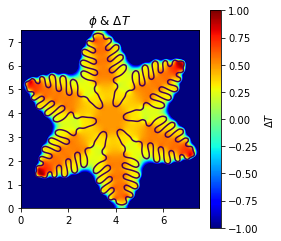

KeyboardInterrupt: ignored

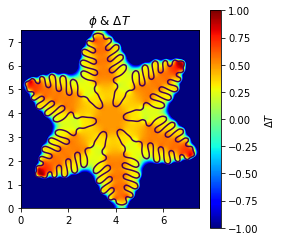

In [0]:
from fipy import Variable, CellVariable, Grid2D, TransientTerm, DiffusionTerm, ImplicitSourceTerm, MultiViewer, Viewer, Matplotlib2DGridViewer
from fipy.tools import numerix

dx = dy = 0.025
nx = ny = 300

mesh = Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)
dt = 5e-4

phase = CellVariable(name=r'$\phi$', mesh=mesh, hasOld=True)
dT = CellVariable(name=r'$\Delta T$', mesh=mesh, hasOld=True)

DT = 2.25
heatEq = (TransientTerm() == DiffusionTerm(DT) + (phase - phase.old) / dt)


alpha = 0.015
c = 0.02
N = 6.0
theta = numerix.pi / 8.0
psi = theta + numerix.arctan2(phase.faceGrad[1], phase.faceGrad[0])
Phi = numerix.tan(N * 0.5 * psi)
PhiSq = Phi ** 2
beta = (1.0 - PhiSq) / (1.0 + PhiSq)
DbetaDpsi = -N * 2.0 * Phi / (1.0 + PhiSq)
Ddia = 1.0 + c * beta
Doff = c * DbetaDpsi
l0 = Variable(value=((1,0),(0,1)))
l1 = Variable(value=((0,-1),(1,0)))
D = alpha**2*(1.0 + c*beta) * (Ddia * l0 + Doff * l1)

tau = 3e-4
kappa1 = 0.9
kappa2 = 20.0
phaseEq = (TransientTerm(tau) == DiffusionTerm(D) + ImplicitSourceTerm((phase - 0.5 - kappa1 / numerix.pi * numerix.arctan(kappa2 * dT)) * (1.0-phase)))

radius = dx * 5.0
C = (nx * dx/2, ny * dy/2)
x,y = mesh.cellCenters
phase.setValue(1.0, where=((x-C[0])**2 + (y - C[1])**2) < radius**2)

dT.setValue(-0.5)


if __name__ == "__main__":
    try:
        import pylab
        class DendriteViewer(Matplotlib2DGridViewer):
            def __init__(self, phase, dT, title=None, limit={}, **kwlimits):
                self.phase = phase
                self.counter = None
                Matplotlib2DGridViewer.__init__(self, vars=(dT,), title=title, limits={}, **kwlimits)

            def _plot(self):
                Matplotlib2DGridViewer._plot(self)

                if self.counter is not None:
                    for c in self.counter.collections:
                        c.remove()

                mesh = self.phase.mesh
                shape = mesh.shape
                x, y = mesh.cellCenters
                z = self.phase.value
                x, y, z = [a.reshape(shape, order='F') for a in (x, y, z)]

                self.counter = self.axes.contour(x, y, z, (0.5,))

        viewer = DendriteViewer(phase=phase, dT=dT, title=r'%s & %s'%(phase.name, dT.name), datamin=-0.1, datamax=0.05)
    except ImportError:
        viewer = MultiViewer(viewers=(Viewer(vars=phase), Viewer(vars=dT, datamin=-0.5, datamax=0.5)))

    steps = 600

    from builtins import range
    from IPython import display

    for i in range(steps):
        phase.updateOld()
        dT.updateOld()
        phaseEq.solve(phase, dt=dt)
        heatEq.solve(dT, dt=dt)

        display.clear_output(wait=True)
        display.display(pylab.gcf())
        
        filename = r'img_{:03}'.format(i)
        pylab.savefig(imgdir+filename)
        viewer.plot()